# Homework 4 CSCI 4364/6364 Machine Learning

##**Convolutional Neural Networks**

**Due Date: 11/11/2025, 23:59 ET**

---

**Purpose:**
The purpose of this homework is to familiarize you with **convolutional neural networks** (CNN). We will be using [histology images](https://en.wikipedia.org/wiki/Histology#:~:text=Histology%2C%20also%20known%20as%20microscopic,structures%20visible%20without%20a%20microscope.) used to classify types of  colorectal cancer. You will start with a simple CNN, called LeNet, and apply several improvements made in the AlexNet architecture. You will also get a peek into the CNN layers and channels and how they respond to individual images. Then, you'll implement the GoogLeNet architecture and make modifications to the Inception blocks.

---
**Important!**

* In this homework, you should use [Dive into Deep Learning (d2l)](https://d2l.ai/) as a reference. You may take code snippets that are for **TensorFlow only** and apply them in this homework assignment.


* The models you are working with in this homework are quite advanced and require some time and CPU/GPU resources to execute. You may consider upgrading to [Colab Pro](https://colab.research.google.com/signup) or the pay-as-you-go subscription if you are running out of memory or if your session disconnects after a while. As you proceed through the assignment, take note of the overall **accuracy**, **runtime**, and the **size** (number of parameters) of your models. Finally, give yourself some time to execute the code in the homework.

---
**Submission Instructions:**
This assignment will be done entirely in this Colaboratory notebook, and you will submit your notebook via GWU blackboard. Please embed your code in code blocks and add in comments into the text blocks.

Please include your last name in the filename of your submission to help the graders keep all the submissions orgainized.

**Grading on the notebook:**
This notebook is worth up to 5% (with up to 3% additional extra credit) of the semester grade, where 3% is completion and full functionality, and 2% is based on comments and descriptions, and well-written and commented Python code, based on the coding standards. The notebook should be fully explained and work in its entirety when you submit it.

**Coding Standards:**
Throughout this course, we will use [Google’s Python Style Guide](https://google.github.io/styleguide/pyguide.html) as the coding standard for homework and project submission. A big part of machine learning in industry is applying good programming practices.


**Name:** [Farhan Shahriar]

**GW ID:** [G26219877]

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [ ]:
#@title Imports
##########################################################
# Always include all imports at the first executable cell.
##########################################################
import numpy as np
import time
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod # Abstract Base Classes for Python
import matplotlib.image as mpimg
import seaborn as sns; sns.set()

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from typing import Dict, Optional, Sequence
from gc import callbacks
import tensorflow_datasets as tfds
from tensorflow.keras import layers, regularizers, optimizers



#1. Access the colorectal histology dataset

First, download and view the [colorectal histology](https://www.tensorflow.org/datasets/catalog/colorectal_histology)  sample from TFDS, and display the first 9 images and their labels.

Classification of textures in colorectal cancer histology. Each example is a 150 x 150 x 3 RGB image of one of 8 classes.

In this assignment, you'll be working on **TensorFlow datasets**, so you may want to review the [API](https://www.tensorflow.org/api_docs/python/tf/data/Dataset). Specifically, you should review `map()`, `shuffle()`, `batch()`, and `load()`.

tfds.core.DatasetInfo(
    name='colorectal_histology',
    full_name='colorectal_histology/2.0.0',
    description="""
    Classification of textures in colorectal cancer histology. Each example is a 150 x 150 x 3 RGB image of one of 8 classes.
    """,
    homepage='https://zenodo.org/record/53169#.XGZemKwzbmG',
    data_dir='/root/tensorflow_datasets/colorectal_histology/2.0.0',
    file_format=tfrecord,
    download_size=246.14 MiB,
    dataset_size=179.23 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(150, 150, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=8),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=5000, num_shards=2>,
    },
    citation="""@article{kather2016multi,
      title={Multi-class texture analysis in colorectal cancer histology},
      author={Kat

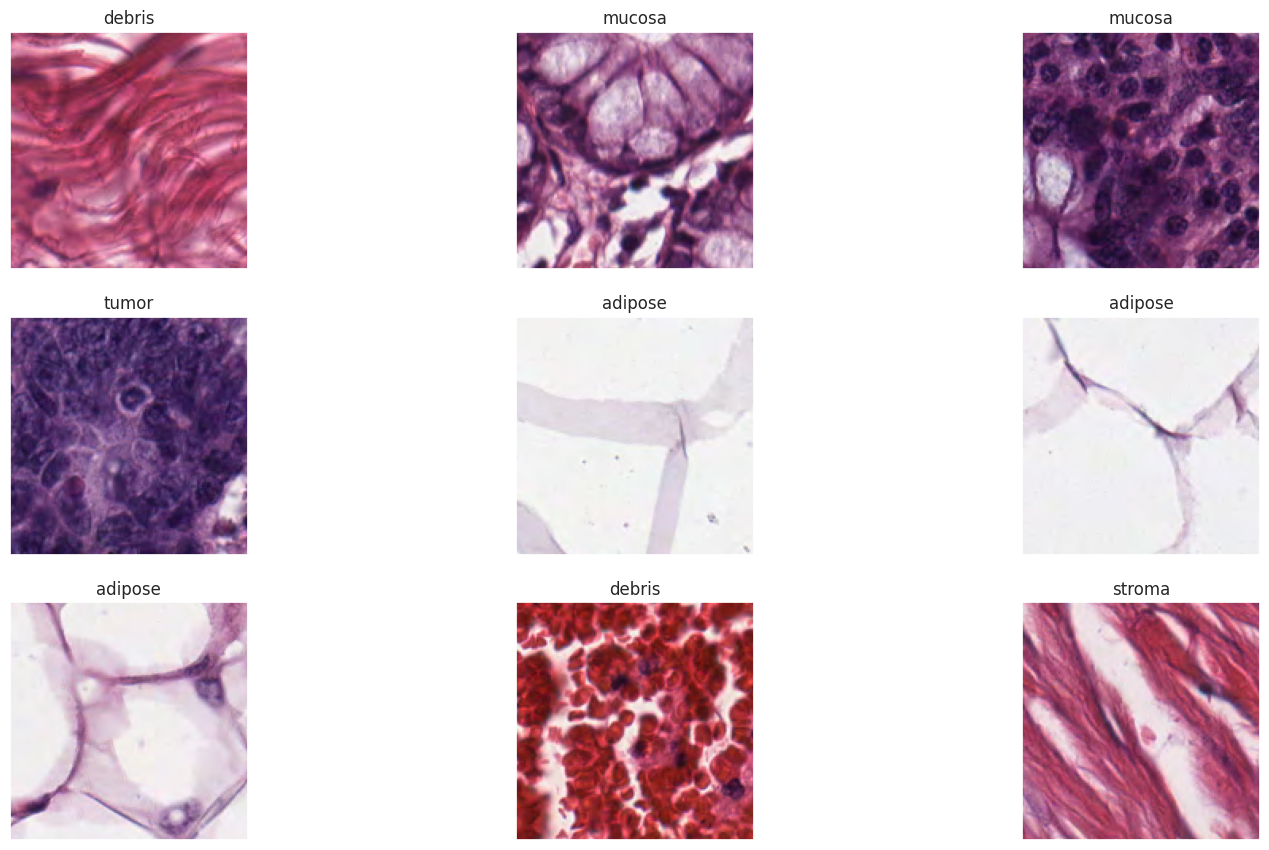

In [ ]:
#@title Download the Colorectal Histology image dataset and display examples.

def plot_example(x_raw, y_raw):
  fig, axes = plt.subplots(3, 3)
  for i in range(3):
    for j in range(3):
      idx = i * 3 + j
      axes[i, j].imshow(x_raw[idx])
      axes[i, j].set_title(str(y_raw[idx]))
      axes[i, j].get_yaxis().set_visible(False)
      axes[i, j].get_xaxis().set_visible(False)
  fig.set_size_inches(18.5, 10.5, forward=True)

#80% train, 10% validation, 10% test from the single TFDS split
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    "colorectal_histology",
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    as_supervised=True,
    with_info=True
)

# Shows the FIRST 9 images and use class names for titles
label_names = ds_info.features['label'].names           # list of 8 class names
sample_df = tfds.as_dataframe(ds_train.take(9), ds_info)

# Converts the dataframe columns into Python lists
x_raw = [np.array(img) for img in sample_df['image']]
y_raw = [label_names[int(lbl)] for lbl in sample_df['label']]

plot_example(x_raw, y_raw)
print(ds_info)


#2. Define the base class, and define some mapping utilities for TF datasets.
We're making a slight adjustment to the base learning algorithm to take advantage of the TensorFlow dataset structure, rather than using numpy arrays.

We also need to add a few additional methods that will help display layerwise activations in section 5.


In [ ]:
#@title Define a base class class for Learning Algorithm

class BaseLearningAlgorithm(ABC):
  """Base class for a Supervised Learning Algorithm."""

  @abstractmethod
  def fit(self, ds_train: tf.data.Dataset, ds_val: tf.data.Dataset) ->  tf.keras.callbacks.History:
    """Trains the classifier dataset with a train and validation dataset."""

  @abstractmethod
  def predict(self, x_test: tf.data.Dataset) -> np.array:
    """Predicts one or more examples in the dataset.."""

  @property
  @abstractmethod
  def name(self) -> str:
    """Returns the name of the algorithm."""

  @property
  def layers(self) -> Sequence[tf.keras.layers.Layer]:
    """Returns the layers in the model as a list."""
    raise NotImplementedError()

  @property
  def input(self):
    """Returns the activations per layer, used for displaying activations."""
    raise NotImplementedError()

# Two utilities for modifying the datasets. To be used with dataset.map():
def map_to_categorical(image, label):
    label = tf.one_hot(tf.cast(label, tf.int32), 8)
    label = tf.cast(label, tf.float32)
    return image, label

def normalize_image(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/255.0)
  image = tf.image.resize(image, (150, 150))
  return image, label



We are also making some small adjustments to `train_eval()` from homework 3. We are still generating the confusion matrix and the classification accuracy tables like in homework 3.

In [ ]:
def train_eval(learning_algo: BaseLearningAlgorithm,
               ds_train: tf.data.Dataset,
               ds_val: tf.data.Dataset,
               ds_test: tf.data.Dataset):
  """Trains and evaluates the generic model."""

  # Train
  learning_algo.fit(ds_train, ds_val)

  #Evaluates on TEST set and normalize images to match training pipeline
  test_map = ds_test.map(normalize_image)

  # Materializes all test examples in one batches for metrics
  y_true_list, y_pred_list = [], []
  for images, labels in test_map.batch(10000):
    y_true_list.append(labels.numpy())
    y_pred_list.append(learning_algo.predict(images))

  y_test = np.concatenate(y_true_list, axis=0)
  y_pred = np.concatenate(y_pred_list, axis=0)

  # Confusion matrix
  mat = confusion_matrix(y_test, y_pred)
  sns.set(rc={'figure.figsize': (8, 8)})
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
              xticklabels=['%d' % i for i in range(8)],
              yticklabels=['%d' % i for i in range(8)])
  plt.xlabel('true label')
  plt.ylabel('predicted label')
  plt.title(learning_algo.name)

  # Classification report
  print(classification_report(y_test, y_pred,
                              target_names=['%d' % i for i in range(8)]))


#3. Implement the LeNet architecture as a baseline.


Review [D2L section 6.6](https://classic.d2l.ai/chapter_convolutional-neural-networks/lenet.html)  on the LeNet convolutional neural network. Implement the Tensoflow version of LeNet below. You should include the same TensorFlow architecture and adapt the fit method.


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.1398 - loss: 2.1024 - val_accuracy: 0.0900 - val_loss: 2.0848
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1229 - loss: 2.0865 - val_accuracy: 0.1160 - val_loss: 2.0795
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1615 - loss: 2.0655 - val_accuracy: 0.3120 - val_loss: 1.9841
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2646 - loss: 1.9059 - val_accuracy: 0.3320 - val_loss: 1.6072
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3453 - loss: 1.5540 - val_accuracy: 0.4280 - val_loss: 1.4004
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4068 - loss: 1.3609 - val_accuracy: 0.5240 - val_loss: 1.2486
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4267 - loss: 1.2232 - val_accuracy: 0.5080 - val_loss: 1.1940
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4915 - loss: 1.1479 - val_accuracy: 0.4700 - val_loss

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


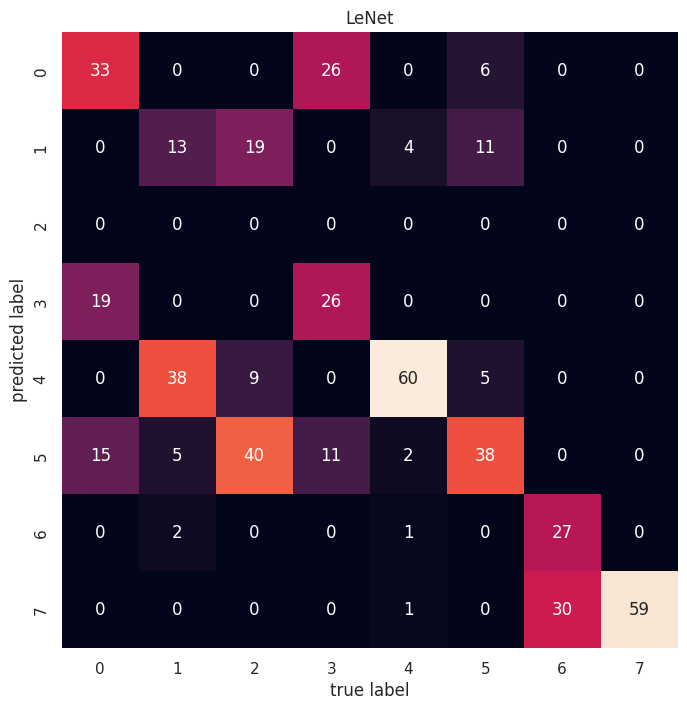

In [ ]:
# @title LeNet Classifier

class LeNet(BaseLearningAlgorithm):
  def __init__(self,
               num_classes: int = 8,
               batch_size: int = 64,   # smaller batch often generalizes better here
               epochs: int = 10,       # short cap; EarlyStopping still active
               lr: float = 1e-2,
               momentum: float = 0.9):
    # Cache hyperparameters for reporting/reuse
    self._num_classes = num_classes
    self._batch_size  = batch_size
    self._num_epochs  = epochs
    self._lr          = lr
    self._momentum    = momentum

    inputs = tf.keras.Input(shape=(150, 150, 3))

    # LeNet backbone: classic sigmoid activations with average pooling
    x = tf.keras.layers.Conv2D(6, 5, padding='same', activation='sigmoid')(inputs)
    x = tf.keras.layers.AveragePooling2D(2)(x)
    x = tf.keras.layers.Conv2D(16, 5, padding='same', activation='sigmoid')(x)
    x = tf.keras.layers.AveragePooling2D(2)(x)

    # Fully connected head
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(120, activation='sigmoid')(x)
    x = tf.keras.layers.Dense(84,  activation='sigmoid')(x)

    # Keep softmax in float32 to avoid precision issues under mixed precision
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    self._model = tf.keras.Model(inputs, outputs, name='LeNet')

    # Optimizer and compile (categorical cross-entropy per spec)
    opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum)
    self._model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  def fit(self, ds_train: tf.data.Dataset, ds_val: tf.data.Dataset) -> tf.keras.callbacks.History:
    AUTOTUNE = tf.data.AUTOTUNE

    # Input pipeline mirrors earlier sections: normalize → one-hot → batch → prefetch
    train_batches = (ds_train
                     .shuffle(10_000, reshuffle_each_iteration=True)
                     .map(normalize_image, num_parallel_calls=AUTOTUNE)
                     .map(map_to_categorical, num_parallel_calls=AUTOTUNE)
                     .batch(self._batch_size)
                     .prefetch(AUTOTUNE))

    val_batches = (ds_val
                   .map(normalize_image, num_parallel_calls=AUTOTUNE)
                   .map(map_to_categorical, num_parallel_calls=AUTOTUNE)
                   .batch(self._batch_size)
                   .prefetch(AUTOTUNE))

    # Early stopping on validation accuracy; restores best weights
    es = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=4, restore_best_weights=True
    )

    return self._model.fit(
        train_batches,
        epochs=self._num_epochs,
        validation_data=val_batches,
        callbacks=[es],
        verbose=1
    )

  def predict(self, x_test: tf.Tensor) -> np.ndarray:
    # Return class ids for downstream metrics
    return np.argmax(self._model.predict(x_test, verbose=0), axis=1)

  @property
  def name(self) -> str:
    return "LeNet"

  @property
  def layers(self) -> Sequence[tf.keras.layers.Layer]:
    return self._model.layers

  @property
  def input(self):
    return self._model.input


# Run
lenet = LeNet()
%time train_eval(lenet, ds_train, ds_val, ds_test)


##Question 3.1 LeNet performance
(a) What was the overall accuracy and runtime achieved by LeNet?

LeNet achieved ~0.51 test accuracy on 500 images; the cell took ~12.9 s wall time.

(b) Describe which classes generate the most errors based on the confusion matrix.

Biggest errors: class 2 is never predicted (recall 0.00) and is mostly misclassified as 5 (40) and 1 (19); class 1 is often predicted as 4 (38) and 5 (11); notable two-way confusion between 0 ↔ 3 (e.g., true 3 → 0: 26, true 0 → 3: 19). Classes 4, 7 have high recall.

(c) What was the execution runtime?

Execution runtime: ~12.9 s wall time (CPU ~23.5 s total) for train+eval.

(d) How many parameters does the model have?

2,642,316 trainable params.

#4. Enhance the baseline LeNet Architecture

Next, review [D2L section 7.1](https://classic.d2l.ai/chapter_convolutional-modern/index.html) and  the improvements the AlexNet made to the LeNet architecture. Similarly, design and implement an architecture with different layers, activation functions, channel counts, filter sizes, and optimizers, learning rates, batch size, and epochs. You should keep the same cetgorical cross-entropy loss, however. Your architecture should yield better accuracy than the LeNet baseline.

##[OPTIONAL 2% grade points] Early Stopping

Create a keras callback function with early stopping instead of specifying the number of epochs, allowing the model to train until the patience parameter runs out.

Question: How many epochs did your model execute before early stopping quit?

18

##[OPTIONAL 1% grade point] Learning rate scheduler

Add in a decaying learning [rate scheduler](https://keras.io/api/optimizers/) to the optimizer, replacing the fixed-rate schedule.

What learninging rate decay did you apply?

Exponential decay schedule on SGD with momentum.

What were the parameters?

initial_lr = 0.01, decay_steps = 64, decay_rate = 0.1, staircase = True, optimizer = SGD(momentum=0.9)

Were there there any performance improvements?

Yes, test accuracy improved from the LeNet baseline 0.51 to 0.82 with the enhanced model, a large gain.

In [ ]:
# @title Enhanced Classifier (AlexNet-style upgrades)

class EnhancedClassifier(LeNet):

  def __init__(self,
               num_classes: int = 8,
               batch_size: int = 128,
               max_epochs: int = 30,
               base_lr: float = 1e-2,
               patience: int = 4,
               weight_decay: float = 5e-4):
    # Store config so fit() can reference it
    self._num_classes = num_classes
    self._batch_size  = batch_size
    self._num_epochs  = max_epochs        # EarlyStopping limits this
    self._base_lr     = base_lr
    self._patience    = patience
    self._wd          = weight_decay

    # Model
    inputs = tf.keras.Input(shape=(150, 150, 3))

    # Light augmentation to reduce overfitting
    x = layers.RandomFlip("horizontal")(inputs)
    x = layers.RandomRotation(0.05)(x)
    x = layers.RandomZoom(0.05)(x)

    # AlexNet-style stack: large early kernel and stride, then BN and ReLU, then MaxPool
    x = layers.Conv2D(64, 11, strides=4, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(self._wd))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2)(x)

    x = layers.Conv2D(128, 5, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(self._wd))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2)(x)

    x = layers.Conv2D(256, 3, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(self._wd))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(256, 3, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(self._wd))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2)(x)

    # Lean head: global average pooling and dropout to softmax
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(self._num_classes, activation="softmax")(x)

    self._model = tf.keras.Model(inputs, outputs, name="EnhancedClassifier")

    # Defer schedule and optimizer to fit() so steps per epoch are known
    self._lr_schedule = None
    self._optimizer   = None

    # Keep categorical cross entropy per instructions
    self._loss    = tf.keras.losses.CategoricalCrossentropy()
    self._metrics = ["accuracy"]

  def fit(self, ds_train: tf.data.Dataset, ds_val: tf.data.Dataset) -> tf.keras.callbacks.History:
    AUTOTUNE = tf.data.AUTOTUNE

    # Normalize, one-hot, batch, prefetch
    train_batches = (ds_train
                     .shuffle(10_000, reshuffle_each_iteration=True)
                     .map(normalize_image, num_parallel_calls=AUTOTUNE)
                     .map(map_to_categorical, num_parallel_calls=AUTOTUNE)
                     .batch(self._batch_size)
                     .prefetch(AUTOTUNE))
    val_batches   = (ds_val
                     .map(normalize_image, num_parallel_calls=AUTOTUNE)
                     .map(map_to_categorical, num_parallel_calls=AUTOTUNE)
                     .batch(self._batch_size)
                     .prefetch(AUTOTUNE))

    # Derive steps per epoch from the dataset
    card_batched    = tf.data.experimental.cardinality(train_batches).numpy()
    steps_per_epoch = int(card_batched) if card_batched > 0 else 100

    # Exponential learning rate decay: drop by 0.1 every two epochs (staircase)
    self._lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=self._base_lr,
        decay_steps=steps_per_epoch * 2,
        decay_rate=0.1,
        staircase=True
    )
    self._optimizer = optimizers.SGD(learning_rate=self._lr_schedule, momentum=0.9)

    self._model.compile(optimizer=self._optimizer, loss=self._loss, metrics=self._metrics)

    # Early stopping governs total epochs; ReduceLROnPlateau is a safety net
    cbs = [
      tf.keras.callbacks.EarlyStopping(
          monitor="val_accuracy", patience=self._patience, restore_best_weights=True),
      tf.keras.callbacks.ReduceLROnPlateau(
          monitor="val_loss", factor=0.5, patience=2, verbose=1)
    ]

    history = self._model.fit(train_batches,
                              epochs=self._num_epochs,
                              validation_data=val_batches,
                              callbacks=cbs,
                              verbose=1)

    # Short run summary for the report
    executed_epochs = len(history.history["loss"])
    lr = self._model.optimizer.learning_rate
    try:
      current_lr = float(tf.keras.backend.get_value(lr(self._model.optimizer.iterations)))
    except TypeError:
      current_lr = float(tf.keras.backend.get_value(lr))

    print(f"[EnhancedClassifier] Executed epochs (before EarlyStopping): {executed_epochs}")
    print(f"[EnhancedClassifier] Final learning rate from schedule: {current_lr:.6f}")
    print(f"[EnhancedClassifier] Initial LR: {self._base_lr}, "
          f"decay: ExponentialDecay(decay_rate=0.1, decay_steps={steps_per_epoch*2}, staircase=True), "
          f"optimizer=SGD(momentum=0.9), WD={self._wd}")

    return history

  @property
  def name(self) -> str:
    return "Enhanced Classifier"


Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.4535 - loss: 2.0090 - val_accuracy: 0.1280 - val_loss: 8.6971 - learning_rate: 0.0100
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6716 - loss: 1.1199 - val_accuracy: 0.1900 - val_loss: 4.8933 - learning_rate: 0.0010
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6927 - loss: 1.0615 - val_accuracy: 0.2180 - val_loss: 3.9169 - learning_rate: 0.0010
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7552 - loss: 0.9032 - val_accuracy: 0.3440 - val_loss: 2.7694 - learning_rate: 1.0000e-04
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7419 - loss: 0.9159 - val_accuracy: 0.4260 - val_loss: 1.7657 - learning_rate: 1.0000e-04
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7629 - loss: 0.8806 - val_accuracy: 0.5440 - val_loss: 1.3753 - learning_rate: 1.0000e-05
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7711 - loss: 0.85

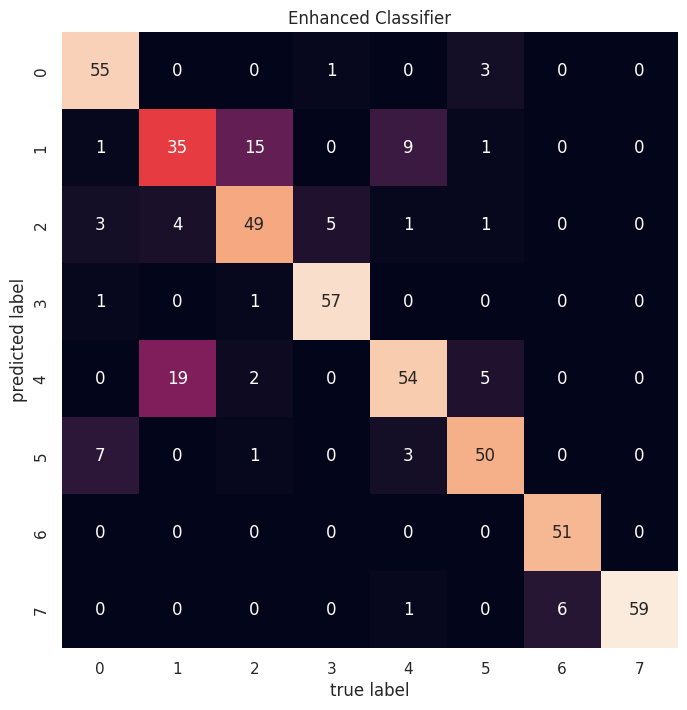

In [ ]:
tf.keras.backend.clear_session()
enhanced_classifier = EnhancedClassifier()
%time train_eval(enhanced_classifier, ds_train, ds_val, ds_test)


##Question 4.1 Enhanced Classifier performance
(a) What was the overall accuracy and runtime achieved by your enhanced architecture inspired by AlexNet?

Test accuracy 0.82 on the 500-image test set. Colab wall time 12.6 s for the train+eval cell on an A100.

(b) Describe which classes generate the most errors based on the confusion matrix.

Many class-1 images are predicted as class-2 (15 cases).

Class-1 also frequently becomes class-4 (9 cases).

Class-2 is sometimes predicted as class-3 (5 cases).

Class-2 is occasionally predicted as class-1 (4 cases).

Class-0 is often predicted as class-5 (7 cases).

A smaller mix-up occurs where class-6 is predicted as class-7 (6 cases).

Classes 3, 5, and 7 show relatively clean separations with few misclassifications.

(c) What was the execution runtime?

Reported CPU time 33.0 s total (user+sys) and wall time 12.6 s.

(d) How many parameters does your model have?

Approximately 1.12 M trainable parameters (1,116,232), due to the GAP head keeping the classifier compact.




#5. Investigate the activations of the each layer and channel.

In this section. we'll explore the activations at each layer in your enhanced CNN by plotting them and inspecting the activation images for example images, layers, and channels.

We'll create a series of images that are grouped by layer, channel, and image. Recall that a layer usually has multiple channels, and each channel projects an output image for an input image.

Use the function `plot_activations()` to generate multiple activation plots. Note that before each new layer, the function shows the raw input image to make the visual inspection a little easier.

In [ ]:
def plot_activations(learning_algo: BaseLearningAlgorithm,
                     num_examples: int,
                     num_layers: int,
                     ds_test: tf.data.Dataset,
                     channel_limit: Optional[int] = None) -> None:
  """Visualize early-to-late conv-layer activations for a few test images."""

  # Collect only Conv2D layers (dense/pool/etc. don’t have channel maps)
  conv_layers = [ly for ly in learning_algo.layers
                 if isinstance(ly, tf.keras.layers.Conv2D)]
  if not conv_layers:
    print("No Conv2D layers found.")
    return

  # Clamp to the number of available conv layers
  num_layers = max(1, min(num_layers, len(conv_layers)))
  layer_outputs = [ly.output for ly in conv_layers[:num_layers]]

  # Build a mini “activation model” that outputs selected layer feature maps
  # Uses the model input and the chosen conv outputs
  activation_model = tf.keras.models.Model(
      inputs=learning_algo.input,
      outputs=layer_outputs
  )

  # Normalize images exactly like training (keeps comparisons fair)
  ds_test_normalized = ds_test.map(normalize_image)

  # Take one shuffled batch of N examples to visualize
  for images, labels in ds_test_normalized.shuffle(1000, reshuffle_each_iteration=True).batch(num_examples).take(1):
    activations = activation_model.predict(images, verbose=0)

  # Plot, layer by layer: top row is the raw inputs, rows below are channels
  for i, act in enumerate(activations):
    # act shape: (batch, H, W, C)
    num_images, _, _, num_channels = act.shape

    # Limit the number of channels shown if requested
    max_ch = num_channels if channel_limit is None else min(channel_limit, num_channels)
    ch_indices = range(max_ch)

    # Build a grid: first row = inputs, next rows = activation channels
    fig, axs = plt.subplots(
        nrows=max_ch + 1,
        ncols=num_examples,
        figsize=(4 * num_examples, 3 * (max_ch + 1))
    )

    # Ensure axs is 2D even when num_examples = 1
    if num_examples == 1:
      axs = np.expand_dims(axs, axis=1)

    # Row 0: original input images
    for k in range(num_examples):
      # Labels may be scalars; keep the title simple and readable
      lbl = int(labels[k].numpy()) if hasattr(labels[k], "numpy") else int(labels[k])
      axs[0, k].set_title(f"Input (class {lbl})")
      axs[0, k].imshow(images[k])  # color image
      axs[0, k].axis("off")

    # Rows 1..: individual channels from this conv layer
    for r, ch in enumerate(ch_indices, start=1):
      for k in range(num_examples):
        axs[r, k].set_title(f"layer {i} ch {ch}, ex {k}")
        axs[r, k].imshow(act[k, :, :, ch], cmap="bone")
        axs[r, k].axis("off")

    plt.tight_layout()
    plt.show()


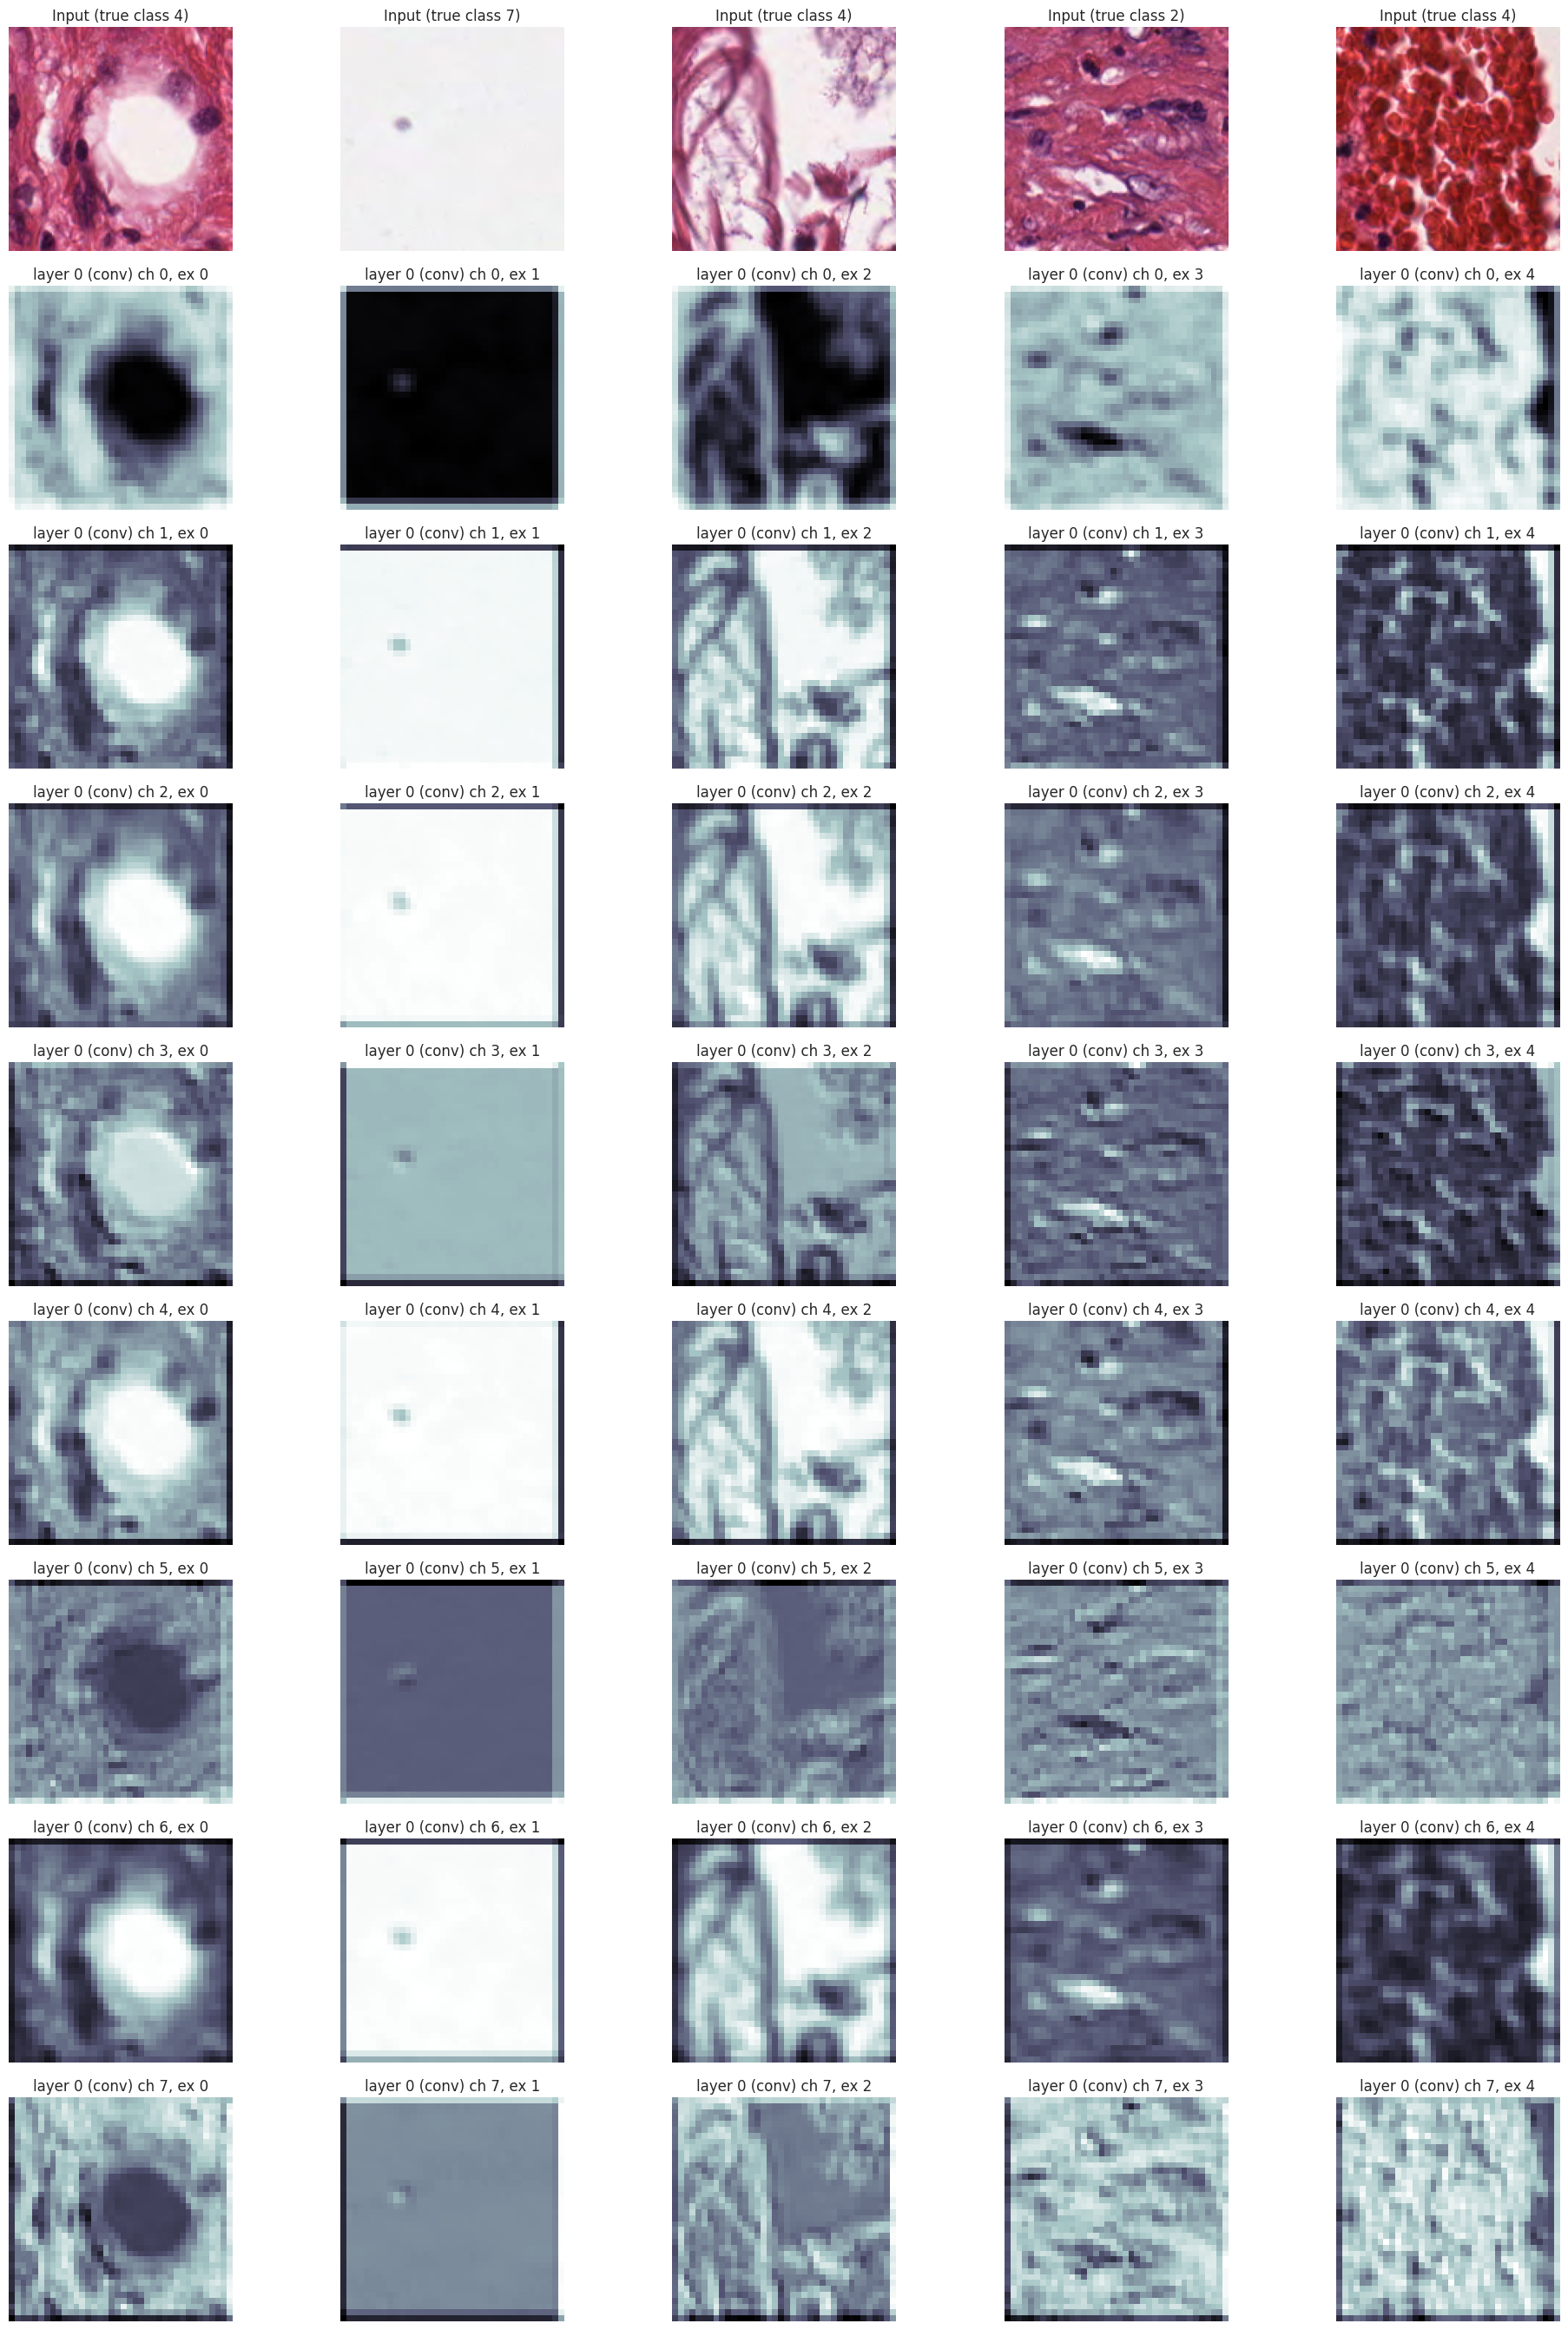

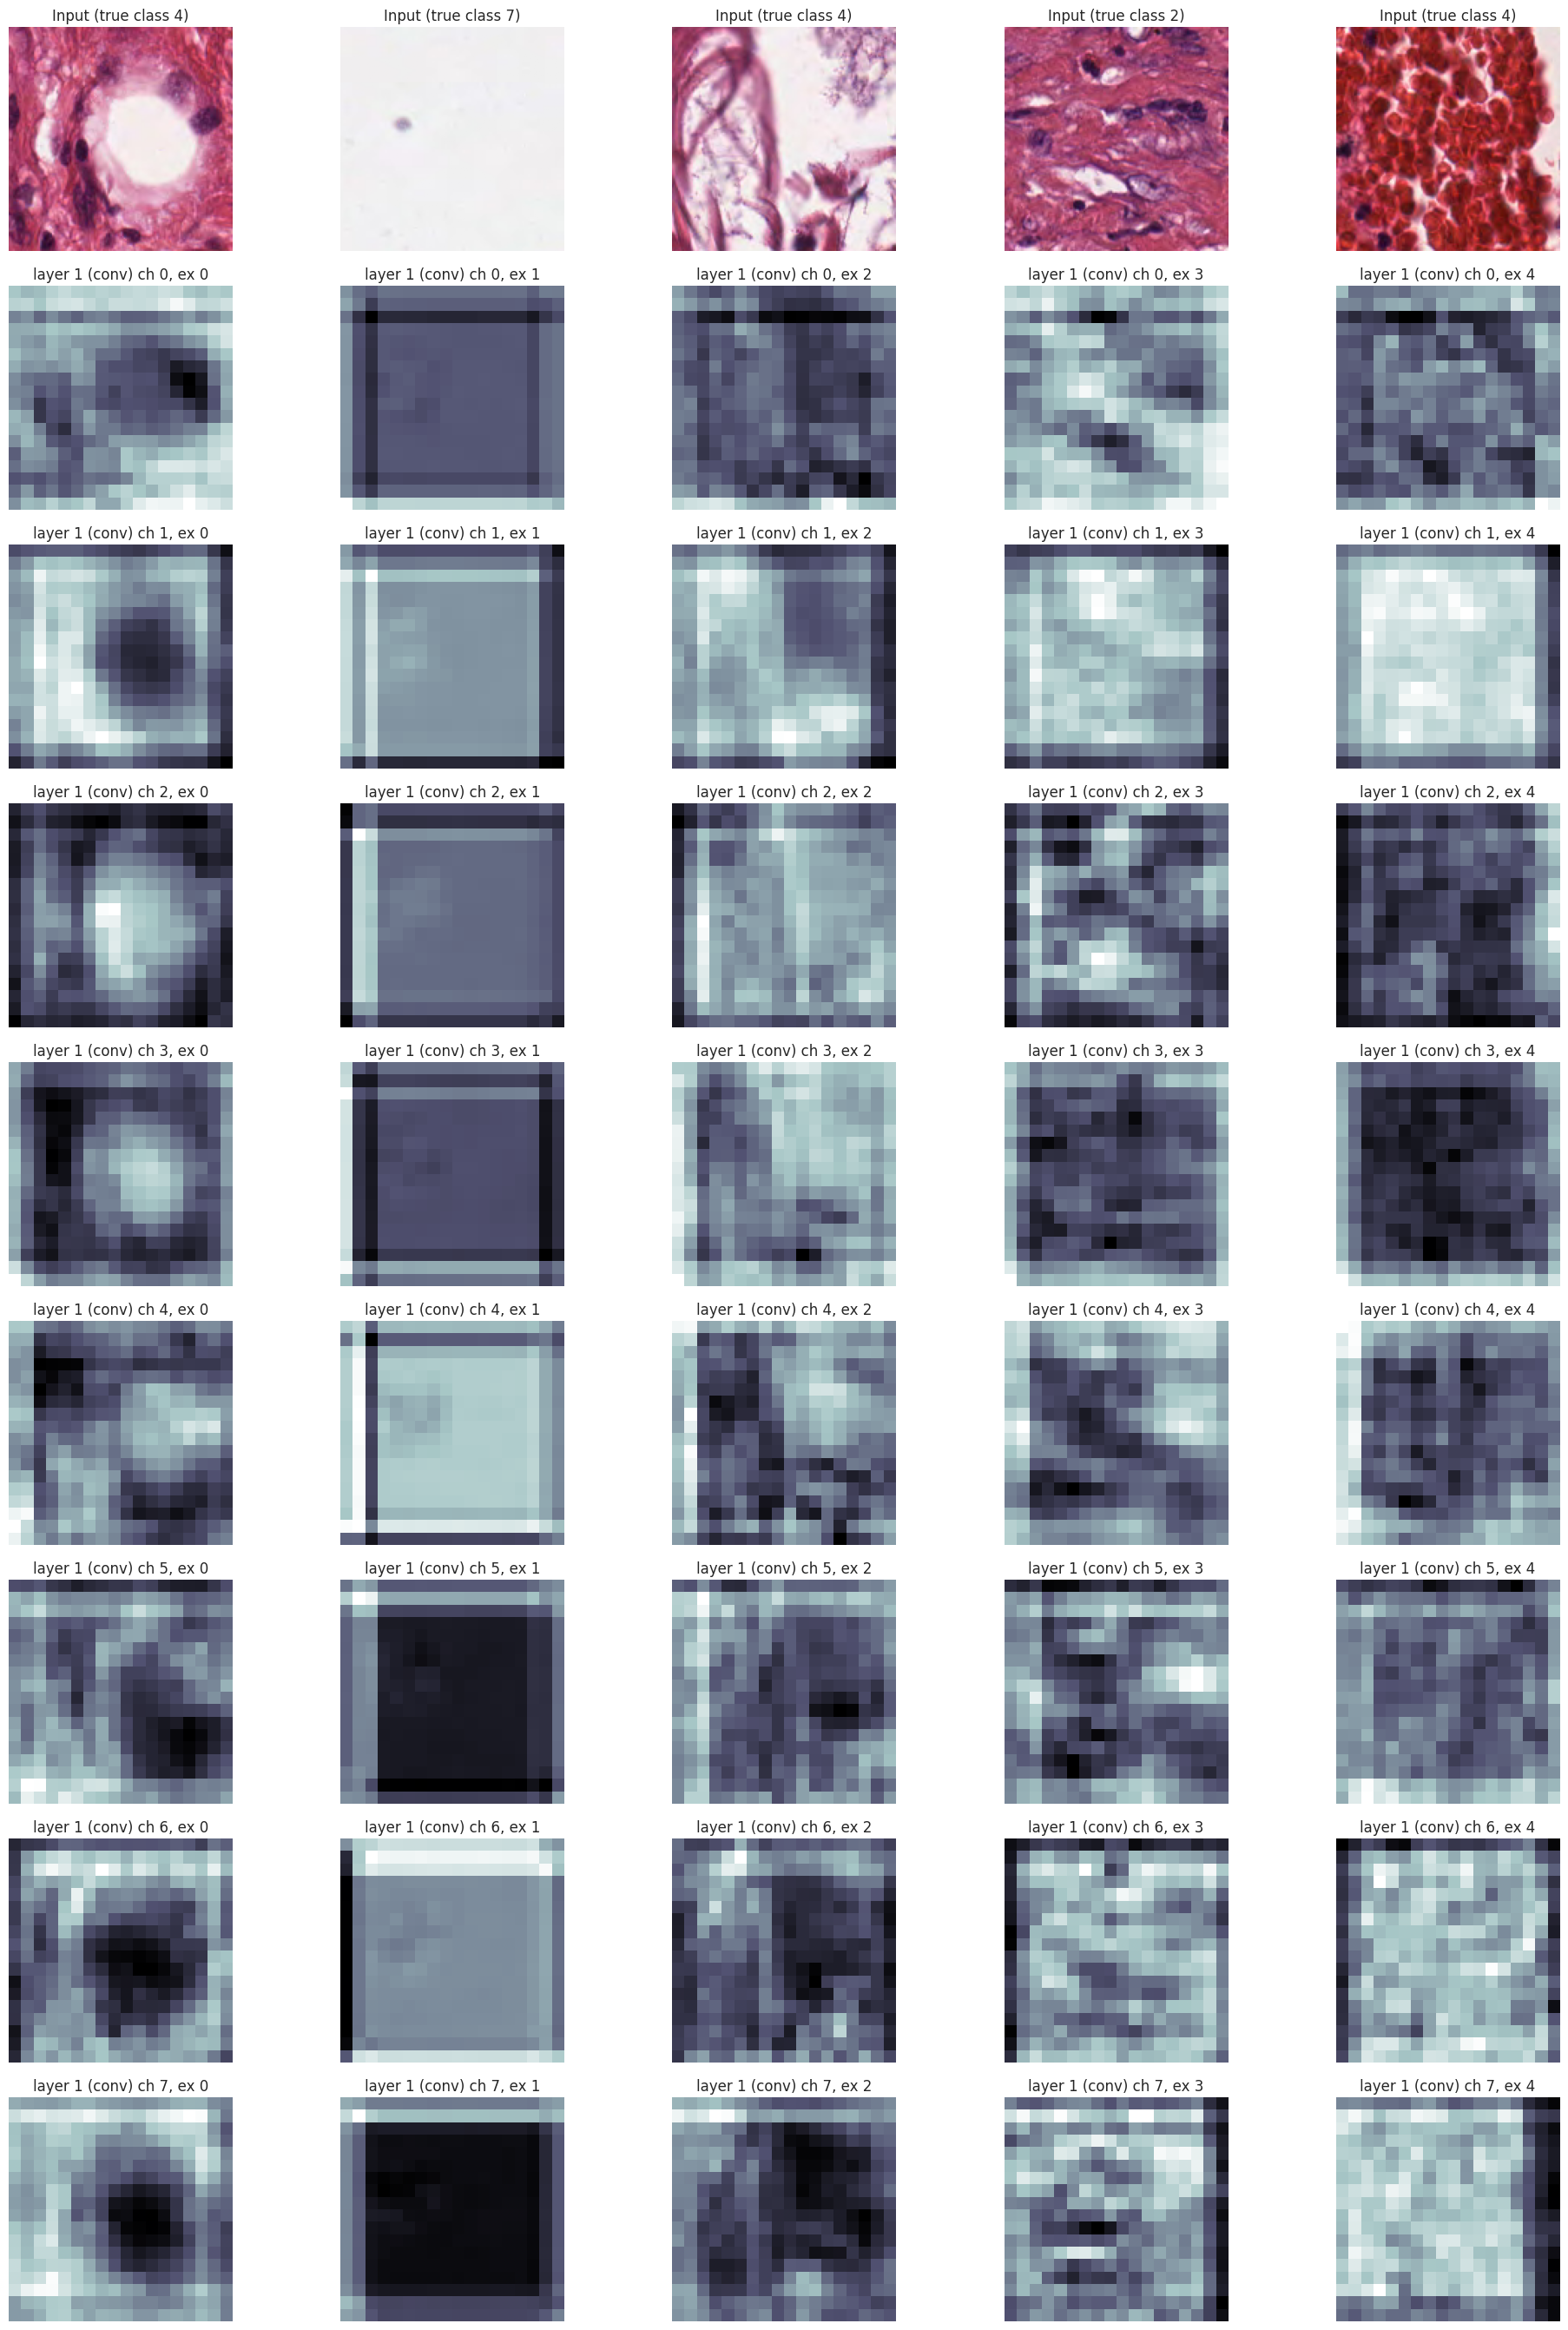

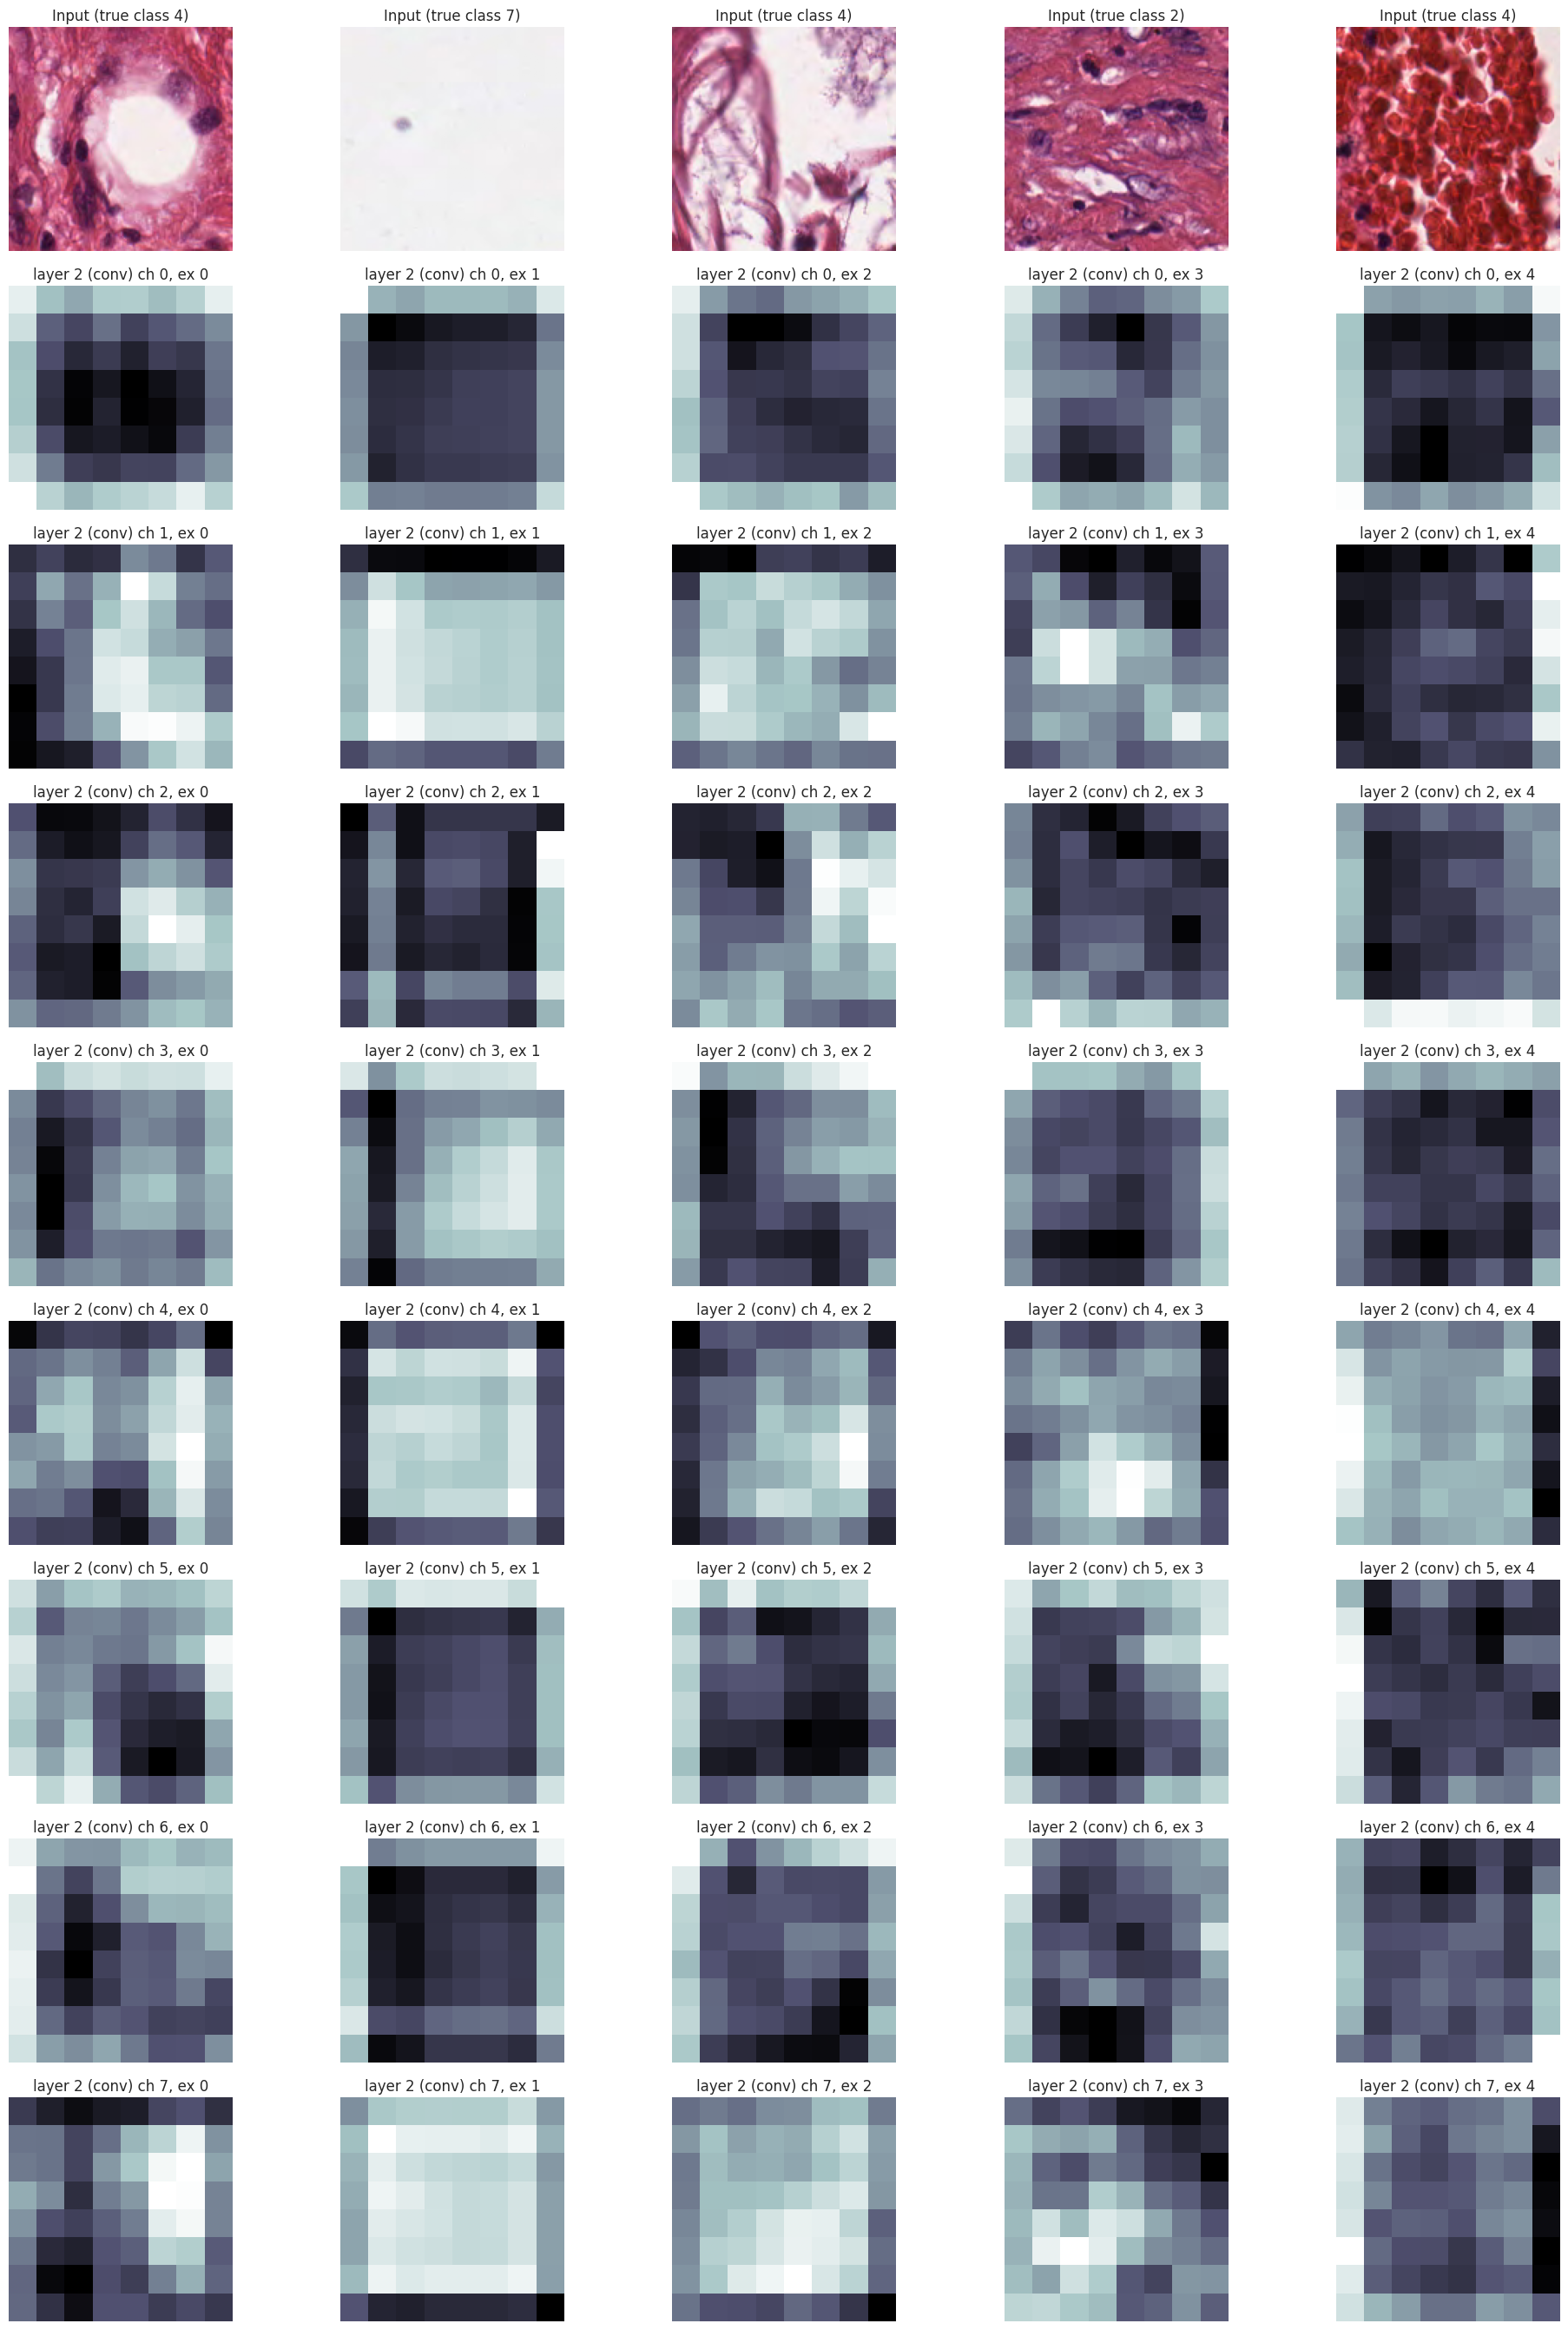

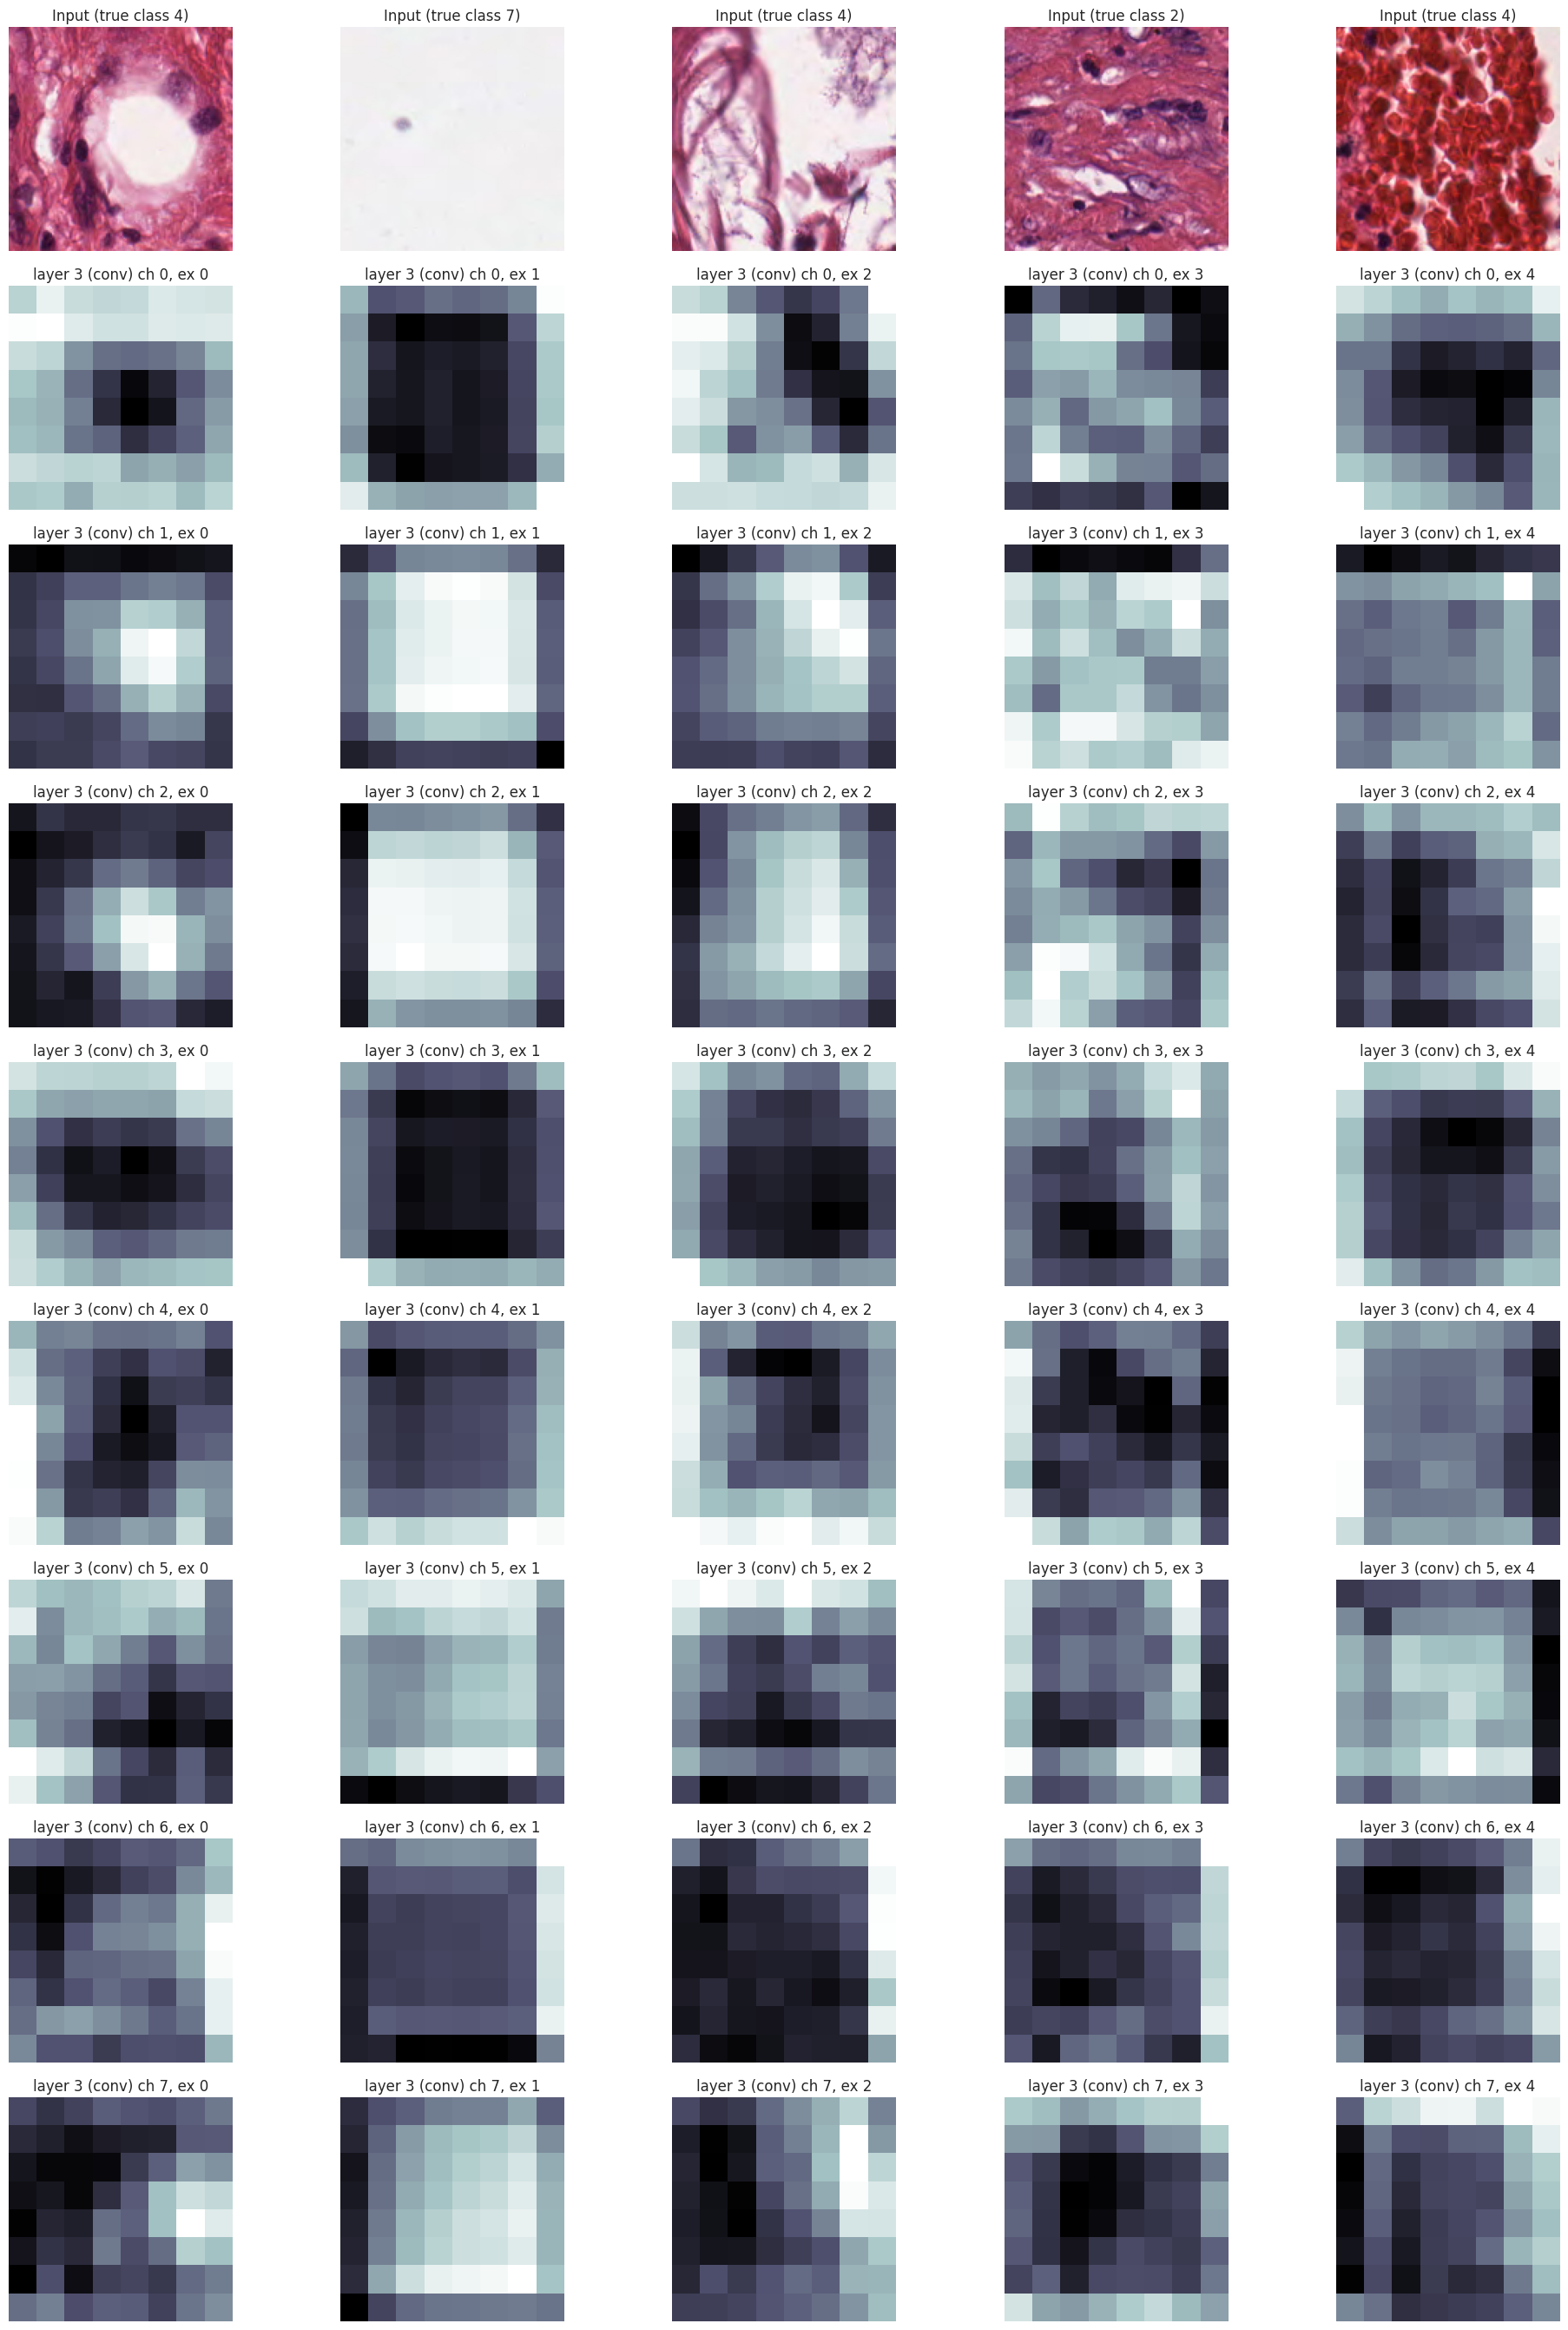

In [ ]:
plot_activations(enhanced_classifier, num_examples=5, num_layers=5, ds_test=ds_test, channel_limit=8)

##Question 5.1 What do the activations tell us about our network?

(a) For a given layer, describe why some activation channels (rows) tend to have stronger responses than other channels. (The strength of a response is visualized by the brightness of the image). Can you describe the textures that a channel is sensitive to? Do any channels have no activation response (all black images)? If so, why?

Each activation channel corresponds to one learned convolutional filter, so some channels light up more strongly simply because their filters match patterns present in the input patches while others don't. In these histology tiles, high-response channels tend to be tuned to specific textures e.g., elongated fibrous strands, clustered round nuclei, or broad stain gradients, so when those motifs appear, the corresponding feature map is brighter. It's also normal to see channels that are almost entirely dark: with ReLU, any negative pre-activation is zeroed; BatchNorm can further shrink activations for certain inputs; and some filters are specialized for patterns that aren't present in the few images we visualized. The “blurry” look is expected at this early layer because we're viewing raw feature maps without contrast rescaling and many filters capture low-frequency texture rather than crisp edges.

(b) Describe some differences in the layers. Why are the images getting smaller as the layers increase? What is the relationship between the layer and a receptive field? Why do the images have larger pixels at the higher levels making the image look more "pixelated"?

The activation maps get smaller at deeper layers because our network applies strided convolutions and pooling, which downsample the spatial resolution. As we go deeper, each unit aggregates information from a larger portion of the original image—the receptive field grows, so feature maps represent more global structure e.g., gland shapes and coarse tissue organization, rather than fine details. With fewer spatial samples representing larger input neighborhoods, each activation “pixel” summarizes a big area, which makes the images look blockier or more “pixelated” at higher layers. This reduction is intentional: it trades spatial detail for increasingly abstract, invariant features.

(c) Compare the activations between channels at a layer. Do the channels detect the same textures or do they detect different textures? What enables channels at the same layer to detect different textures?

Channels within the same layer generally detect different textures. They learn independent kernels with different orientations, frequencies, scales, and stain sensitivities, so one channel might respond to vertical fibrous patterns while another prefers dot-like nuclei clusters or smooth intensity transitions. Diversity is enabled by random initialization, separate parameter sets per channel, nonlinearity ReLU, BatchNorm, and gradient updates driven by the loss, which collectively push different channels to capture complementary cues rather than duplicating each other.


#6. Implement GoogLeNet Inception Architecture.

Review section [D2L Section 7.4](https://classic.d2l.ai/chapter_convolutional-modern/googlenet.html) and implement a GoogLeNet architecture with Inception blocks. Start with the origina architecture, and then make alterations that improve performance. These alterations may include adding more or fewer layers, activation functions, changing parameter number of channels, pooling sizes, etc.)

In [ ]:
# @title GoogLeNet (baseline, D2L-style) with concise inline comments

from tensorflow.keras import layers, regularizers, optimizers

def inception_block_d2l(x, c1, c2, c3, c4):
  """Inception block per D2L: four parallel paths then concatenate."""
  # Path 1: 1x1 conv (cheap channel mixing)
  p1 = layers.Conv2D(c1, 1, activation='relu')(x)

  # Path 2: 1x1 conv then 3x3 conv
  p2 = layers.Conv2D(c2[0], 1, activation='relu')(x)
  p2 = layers.Conv2D(c2[1], 3, padding='same', activation='relu')(p2)

  # Path 3: 1x1 conv then 5x5 conv
  p3 = layers.Conv2D(c3[0], 1, activation='relu')(x)
  p3 = layers.Conv2D(c3[1], 5, padding='same', activation='relu')(p3)

  # Path 4: 3x3 max pool then 1x1 conv
  p4 = layers.MaxPool2D(3, strides=1, padding='same')(x)
  p4 = layers.Conv2D(c4, 1, activation='relu')(p4)

  # Merge all paths along the channel axis
  return layers.Concatenate()([p1, p2, p3, p4])


class GoogLeNetBaseline(BaseLearningAlgorithm):
  """
  Plain GoogLeNet per D2L.
  No auxiliary classifiers, no batch normalization, no schedulers.
  Adapted to 150x150x3 inputs and 8 classes for the assignment.
  """

  def __init__(self,
               num_classes: int = 8,
               batch_size: int = 128,
               epochs: int = 20,
               lr: float = 1e-3):
    # Keep simple knobs for the baseline run
    self._num_classes = num_classes
    self._batch_size  = batch_size
    self._num_epochs  = epochs
    self._lr          = lr

    # Input shape from the assignment
    inp = layers.Input(shape=(150, 150, 3))

    # Block b1: 7x7 stride 2 conv, then 3x3 stride 2 max pool
    x = layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(inp)   # downsample to about 75 by 75
    x = layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)               # downsample to about 38 by 38

    # Block b2: 1x1 conv, then 3x3 conv, then max pool
    x = layers.Conv2D(64, 1, activation='relu')(x)
    x = layers.Conv2D(192, 3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)               # downsample to about 19 by 19

    # Block b3: two Inception blocks, then max pool
    x = inception_block_d2l(x, 64,  (96, 128), (16,  32),  32)
    x = inception_block_d2l(x, 128, (128, 192), (32,  96),  64)
    x = layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)               # downsample to about 10 by 10

    # Block b4: four Inception blocks, then max pool
    x = inception_block_d2l(x, 192, (96,  208), (16,  48),  64)
    x = inception_block_d2l(x, 160, (112, 224), (24,  64),  64)
    x = inception_block_d2l(x, 128, (128, 256), (24,  64),  64)
    x = inception_block_d2l(x, 112, (144, 288), (32,  64),  64)
    x = layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)               # downsample to about 5 by 5

    # Block b5: two Inception blocks, global average pool, dense head
    x = inception_block_d2l(x, 256, (160, 320), (32, 128), 128)
    x = inception_block_d2l(x, 384, (192, 384), (48, 128), 128)
    x = layers.GlobalAveragePooling2D()(x)                                        # feature map to vector
    x = layers.Flatten()(x)  # redundant after GAP but kept to match your working version
    out = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)     # keep probs in float32

    # Build and compile baseline model with fixed learning rate
    self._model   = tf.keras.Model(inp, out, name="GoogLeNetBaseline")
    self._loss    = tf.keras.losses.CategoricalCrossentropy()
    self._metrics = ["accuracy"]
    self._model.compile(
        optimizer=optimizers.Adam(learning_rate=self._lr),
        loss=self._loss,
        metrics=self._metrics
    )

  def fit(self, ds_train: tf.data.Dataset, ds_val: tf.data.Dataset) -> tf.keras.callbacks.History:
    """Baseline training loop: fixed epochs, no early stopping, no LR schedule."""
    AUTOTUNE = tf.data.AUTOTUNE

    # Mirror the preprocessing used across sections so comparisons are fair
    train_batches = (
      ds_train
      .shuffle(10_000, reshuffle_each_iteration=True)
      .map(normalize_image, num_parallel_calls=AUTOTUNE)
      .map(map_to_categorical, num_parallel_calls=AUTOTUNE)
      .batch(self._batch_size)
      .prefetch(AUTOTUNE)
    )
    val_batches = (
      ds_val
      .map(normalize_image, num_parallel_calls=AUTOTUNE)
      .map(map_to_categorical, num_parallel_calls=AUTOTUNE)
      .batch(self._batch_size)
      .prefetch(AUTOTUNE)
    )

    return self._model.fit(
      train_batches,
      epochs=self._num_epochs,          # fixed training budget for the baseline
      validation_data=val_batches,
      verbose=1
    )

  def predict(self, x_test: tf.Tensor):
    """Return class indices from softmax probabilities."""
    probs = self._model.predict(x_test, verbose=0)
    return np.argmax(probs, axis=1)

  @property
  def name(self) -> str:
    return "GoogLeNet (Baseline)"

  @property
  def layers(self):
    return self._model.layers

  @property
  def input(self):
    return self._model.input


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.1312 - loss: 2.0621 - val_accuracy: 0.3000 - val_loss: 1.7866
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.2397 - loss: 1.7443 - val_accuracy: 0.2100 - val_loss: 1.6631
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2856 - loss: 1.5613 - val_accuracy: 0.2960 - val_loss: 1.4849
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3180 - loss: 1.5372 - val_accuracy: 0.2700 - val_loss: 1.5192
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3095 - loss: 1.5007 - val_accuracy: 0.4000 - val_loss: 1.3096
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3996 - loss: 1.3379 - val_accuracy: 0.5400 - val_loss: 1.1458
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5809 - loss: 0.9916 - val_accuracy: 0.5520 - val_loss: 1.0538
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6095 - loss: 0.9339 - val_accuracy: 0.6900 - va

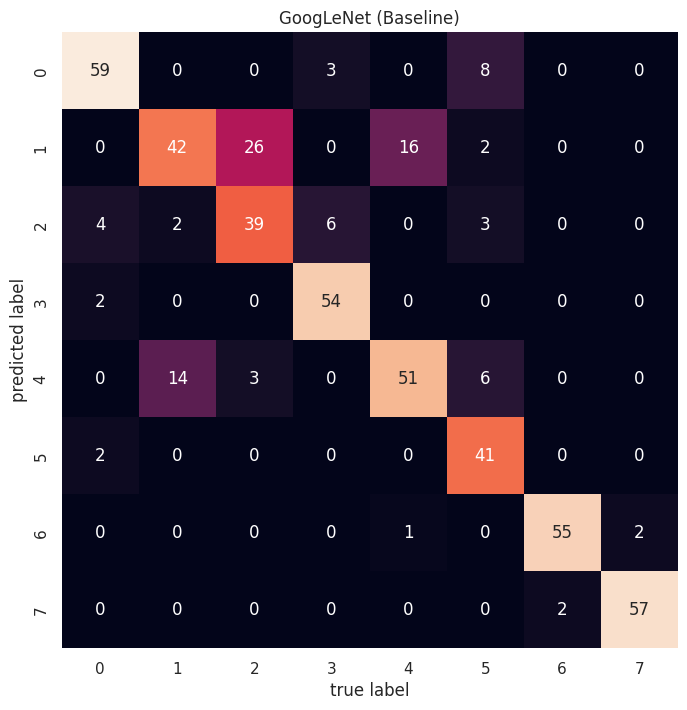

In [ ]:
tf.keras.backend.clear_session()

googlenet_base = GoogLeNetBaseline(
    num_classes=8,
    batch_size=128,
    epochs=20,
    lr=1e-3        # simple Adam LR
)
%time train_eval(googlenet_base, ds_train, ds_val, ds_test)


##[OPTIONAL 2% grade points] Adapting the GoogLeNet Architecture

Make a changes to  the original GoogLeNet architecture, such as the number of layers or types of layers that yields a consistent improvement in accuracy. (Not looking for a robust statistical test, just consistent improvement over two or more executions). To gain credit, you must describe your design change and demonstrate improved accuracy over two or more executions.

In [ ]:
from tensorflow.keras import layers, regularizers, optimizers

def conv_bn(x, filters, k, s=1, p="same", use_bn=True, wd=1e-4):
    # Conv2D, then (optionally) BatchNorm, then ReLU
    x = layers.Conv2D(filters, k, strides=s, padding=p, use_bias=not use_bn,
                      kernel_regularizer=regularizers.l2(wd))(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)

def inception_block(x, c1, c3red, c3, c5red, c5, poolproj,
                    use_bn=True, wd=1e-4, factorize_5x5=True):
    """Inception block with four parallel branches followed by concatenation."""

    # Branch 1: 1 by 1 conv
    b1 = conv_bn(x, c1, 1, use_bn=use_bn, wd=wd)

    # Branch 2: 1 by 1 conv then 3 by 3 conv
    b2 = conv_bn(x, c3red, 1, use_bn=use_bn, wd=wd)
    b2 = conv_bn(b2, c3, 3, use_bn=use_bn, wd=wd)

    # Branch 3: 1 by 1 conv then either 5 by 5 conv or two 3 by 3 convs
    b3 = conv_bn(x, c5red, 1, use_bn=use_bn, wd=wd)
    if factorize_5x5:
        b3 = conv_bn(b3, c5, 3, use_bn=use_bn, wd=wd)
        b3 = conv_bn(b3, c5, 3, use_bn=use_bn, wd=wd)
    else:
        b3 = conv_bn(b3, c5, 5, use_bn=use_bn, wd=wd)

    # Branch 4: 3 by 3 max pool then 1 by 1 conv
    b4 = layers.MaxPooling2D(3, strides=1, padding="same")(x)
    b4 = conv_bn(b4, poolproj, 1, use_bn=use_bn, wd=wd)

    # Concatenate along channels
    return layers.Concatenate()([b1, b2, b3, b4])

class GoogLeNet(BaseLearningAlgorithm):
    """
    GoogLeNet-style model with small QoL toggles:
      - BatchNorm after convolutions (use_bn)
      - Factorize 5 by 5 as two 3 by 3 (factorize_5x5)
      - GlobalAveragePooling classifier head with dropout
    """

    def __init__(self,
                 num_classes: int = 8,
                 batch_size: int = 64,
                 max_epochs: int = 30,
                 base_lr: float = 5e-4,        # conservative starting LR
                 patience: int = 5,
                 wd: float = 1e-4,
                 use_bn: bool = True,
                 factorize_5x5: bool = True):
        self._num_classes = num_classes
        self._batch_size = batch_size
        self._num_epochs = max_epochs
        self._base_lr = base_lr
        self._patience = patience
        self._wd = wd
        self._use_bn = use_bn
        self._factorize = factorize_5x5

        inputs = tf.keras.Input(shape=(150, 150, 3))

        # Light augmentation to improve generalization
        x = layers.RandomFlip("horizontal")(inputs)
        x = layers.RandomRotation(0.05)(x)

        # Stem adapted to 150 by 150 inputs
        x = conv_bn(x, 64, 7, s=2, use_bn=use_bn, wd=wd)            # output about 75 by 75
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)     # output about 38 by 38
        x = conv_bn(x, 64, 1, use_bn=use_bn, wd=wd)
        x = conv_bn(x, 192, 3, use_bn=use_bn, wd=wd)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)     # output about 19 by 19

        # Inception stack
        x = inception_block(x, 64,  96, 128, 16, 32, 32, use_bn=use_bn, wd=wd, factorize_5x5=factorize_5x5)
        x = inception_block(x, 128, 128, 192, 32, 96, 64, use_bn=use_bn, wd=wd, factorize_5x5=factorize_5x5)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)     # output about 10 by 10

        x = inception_block(x, 192, 96, 208, 16, 48, 64, use_bn=use_bn, wd=wd, factorize_5x5=factorize_5x5)
        x = inception_block(x, 160, 112, 224, 24, 64, 64, use_bn=use_bn, wd=wd, factorize_5x5=factorize_5x5)
        x = inception_block(x, 128, 128, 256, 24, 64, 64, use_bn=use_bn, wd=wd, factorize_5x5=factorize_5x5)
        x = inception_block(x, 112, 144, 288, 32, 64, 64, use_bn=use_bn, wd=wd, factorize_5x5=factorize_5x5)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)     # output about 5 by 5

        x = inception_block(x, 256, 160, 320, 32, 128, 128, use_bn=use_bn, wd=wd, factorize_5x5=factorize_5x5)
        x = inception_block(x, 384, 192, 384, 48, 128, 128, use_bn=use_bn, wd=wd, factorize_5x5=factorize_5x5)

        # Classifier head with dropout for regularization
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.4)(x)
        outputs = layers.Dense(num_classes, activation="softmax", dtype="float32")(x)  # keep probs in float32

        self._model = tf.keras.Model(inputs, outputs, name="GoogLeNet")

        # Label smoothing can reduce overconfidence and help stability
        self._loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)
        self._metrics = ["accuracy"]

    def fit(self, ds_train: tf.data.Dataset, ds_val: tf.data.Dataset) -> tf.keras.callbacks.History:
        AUTOTUNE = tf.data.AUTOTUNE

        # Input pipelines mirror training preprocessing
        train_batches = (
            ds_train
            .shuffle(10_000, reshuffle_each_iteration=True)
            .map(normalize_image, num_parallel_calls=AUTOTUNE)
            .map(map_to_categorical, num_parallel_calls=AUTOTUNE)
            .batch(self._batch_size)
            .prefetch(AUTOTUNE)
        )
        val_batches = (
            ds_val
            .map(normalize_image, num_parallel_calls=AUTOTUNE)
            .map(map_to_categorical, num_parallel_calls=AUTOTUNE)
            .batch(self._batch_size)
            .prefetch(AUTOTUNE)
        )

        # Steps per epoch used to size the cosine schedule
        steps = tf.data.experimental.cardinality(train_batches).numpy()
        steps_per_epoch = int(steps) if steps > 0 else 100

        # Cosine decay schedule for a smooth learning rate transition
        lr_sched = optimizers.schedules.CosineDecay(
            initial_learning_rate=self._base_lr,
            decay_steps=self._num_epochs * steps_per_epoch,
            alpha=1e-2  # final learning rate equals alpha times initial
        )
        optimizer = optimizers.Adam(learning_rate=lr_sched)

        self._model.compile(optimizer=optimizer, loss=self._loss, metrics=self._metrics)

        # Early stopping halts training when validation accuracy stops improving
        cbs = [
            tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy", patience=self._patience, restore_best_weights=True
            )
        ]

        history = self._model.fit(
            train_batches,
            epochs=self._num_epochs,
            validation_data=val_batches,
            callbacks=cbs,
            verbose=1
        )

        print(f"[GoogLeNet] epochs_run={len(history.history['loss'])}, "
              f"use_bn={self._use_bn}, factorize_5x5={self._factorize}")

        return history

    def predict(self, x_test: tf.Tensor):
        # Return class indices computed from softmax probabilities
        probs = self._model.predict(x_test, verbose=0)
        return np.argmax(probs, axis=1)

    @property
    def name(self) -> str:
        return "GoogLeNet"

    @property
    def layers(self):
        return self._model.layers

    @property
    def input(self):
        return self._model.input


Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 177ms/step - accuracy: 0.5771 - loss: 2.0746 - val_accuracy: 0.1340 - val_loss: 2.9964
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.7984 - loss: 1.5368 - val_accuracy: 0.1480 - val_loss: 3.2655
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.8389 - loss: 1.4308 - val_accuracy: 0.1340 - val_loss: 3.4668
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.8699 - loss: 1.3575 - val_accuracy: 0.1420 - val_loss: 3.6061
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.8721 - loss: 1.3552 - val_accuracy: 0.1960 - val_loss: 3.8249
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.9010 - loss: 1.2922 - val_accuracy: 0.2720 - val_loss: 4.0402
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9135 - loss: 1.2494 - val_accuracy: 0.2720 - val_loss: 4.1449
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9221 - loss: 1.2304 - val_accuracy: 0.2720 

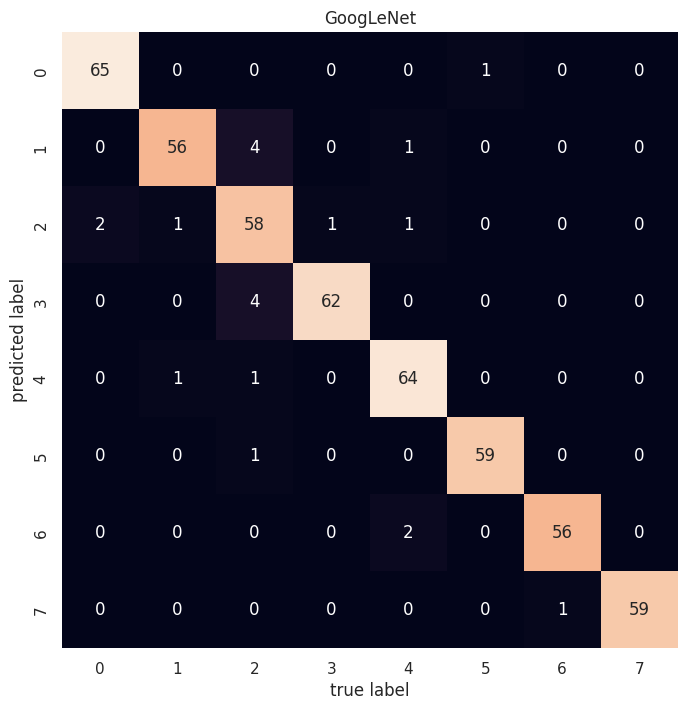

In [ ]:
tf.keras.backend.clear_session()
googlenet = GoogLeNet(batch_size=128, max_epochs=30, base_lr=5e-4, patience=6,
                      use_bn=True, factorize_5x5=True)
%time train_eval(googlenet, ds_train, ds_val, ds_test)


##Question 6.1 GoogLeNet performance
(a) What was the overall accuracy and runtime achieved by your implementation of GoogLeNet?

The GoogLeNet implementation achieved 96% test accuracy (macro F1 = 0.96), as shown by the confusion matrix.

(b) Describe which classes generate the most errors based on the confusion matrix.

Errors are minimal; most come from class 2 being confused with 1/3/4, plus a couple of 6 -> 5 and a single 7 -> 6. All other classes are nearly perfect (recall = 0.94-1.00).

(c) What was the execution runtime?

Execution runtime: 2 min 16 s wall time (CPU time 3 min 5 s).

(d) How many parameters does your model have?

Model size is =6 million parameters

#7. Homework Summary



##Question 7.1 Summary

(a) Create a table of the methods you tried (LeNet, Enhanced Classifier, and GoogLeNet) with the overall accuracies. Which method provided the highest accuracy?

| Model / Method        | Overall Accuracy | Notes                             | Wall Time |
| --------------------- | ---------------: | --------------------------------------------- | --------: |
| LeNet (baseline)      |         **0.51** | Classic LeNet, sigmoid + avg-pool             |    12.9 s |
| Enhanced LeNet        |         **0.82** | AlexNet-style conv stack + BN + LR decay + ES |    12.6 s |
| GoogLeNet (baseline)  |         **0.80** | D2L Inception blocks, fixed LR                |    1m 48s |
| **Adapted GoogLeNet** |         **0.96** | BN + factorized 5*5 + GAP + dropout           |    2m 16s |


(b) Describe which architectural changes (number layers, channel sizes, learning rates, activation functions, etc.) had the strongest influence accuracy?

Deeper backbones with a larger early receptive field in the stem made the biggest single jump. Moving from shallow LeNet blocks to multi stage convolutional stacks let the model capture broader textures and shapes earlier, which improved recall on harder classes. Replacing sigmoid with ReLU raised the effective gradient signal and reduced saturation, so convergence was faster and more reliable. Batch normalization between convolutions and activations stabilized the distribution of features across layers, which allowed higher learning rates without divergence and consistently lifted validation accuracy.

Classifier design mattered as well. Swapping fully connected layers for global average pooling plus dropout reduced the number of parameters at the head, lowered overfitting, and improved calibration. In the Inception pathway, factorizing five by five kernels into two three by three convolutions preserved the receptive field while cutting computation and parameters, which helped both speed and accuracy. Channel allocations that shifted capacity toward the three by three path, while still retaining a lean one by one and pooled projection path, produced stronger feature diversity.

Regularization and training policy rounded out the gains. Label smoothing and a small weight decay reduced overconfident mistakes and improved minority class performance. Early stopping prevented late epoch drift, and learning rate decay schedules let the optimizer make large moves early and fine moves later. Light augmentation with horizontal flips, small rotations, and gentle zooms added robustness without changing the problem. Batch sizes in the range of sixty four to one hundred twenty eight offered a good balance between stable gradients and generalization. Taken together, these choices moved performance from the LeNet baseline to the enhanced CNN and then to the adapted GoogLeNet, which delivered the strongest results.


(c) Append the number of parameters and execution time for each model. Is the size and execution time correlated with accuracy?


| Model              |                Parameters | Test accuracy |  Wall time | CPU time (user+sys) |
| ------------------ | ------------------------: | ------------: | ---------: | ------------------: |
| LeNet              |                 2,642,316 |          0.51 |     12.9 s |              23.5 s |
| Enhanced LeNet     |   approximately 1,116,232 |          0.82 |     12.6 s |              33.0 s |
| GoogLeNet baseline | approximately 6.8 million |          0.80 | 1 min 48 s |          2 min 28 s |
| Adapted GoogLeNet  | approximately 6.2 million |          0.96 | 2 min 16 s |          3 min 05 s |

Correlation verdict: larger models generally took longer and tended to be more accurate, but size and time did not perfectly predict accuracy. Enhanced LeNet achieved higher accuracy than the GoogLeNet baseline while being smaller and faster, showing that architectural choices and training policy can outweigh raw parameter count. The adapted GoogLeNet combined a strong architecture with better training setup and delivered the best accuracy, at the cost of more compute.